# Exploratory Data Analysis

In [1]:
from scipy.stats import pearsonr, shapiro
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import wordcloud as wc

## Preprocessing

Before exploring our data, it is crucial to first clean it and remove any duplicate (title, author).

In [2]:
df = pd.read_csv("./../data/goodreads_data.csv", converters={"genres": lambda x: x[1:-1].split(",")})
df["publication_date"] = pd.to_datetime(df["published"].apply(lambda x: " ".join(str(x).split()[:3])), errors="coerce")
df["publication_year"] = df["publication_date"].dt.year.astype("float")
df["n_pages"] = df["pages_format"].apply(lambda x: int(x.split()[0]) if x.split()[0].isdigit() else np.nan).astype("float")
df["format"] = df["pages_format"].apply(lambda x: x.replace("Kindle Edition", "Kindle").split()[-1].lower() if x.replace("Kindle Edition", "Kindle").split()[-1].lower() in ["hardcover", "paperback", "ebook", "audiobook", "audio", "cd", "kindle"] else "other").astype("category")

dic_rating = {1: "one_star", 2: "two_stars", 3: "three_stars", 4: "four_stars", 5: "five_stars"}
for key, value in dic_rating.items():
    df[value] = df["ratings"].apply(lambda x: float(x[1:-1].split(",")[key-1])) / df["n_ratings"]
df["average_rating"] = df["ratings"].apply(lambda x: sum([(i+1) * float(x[1:-1].split(",")[i]) for i in range(5)])) / df["n_ratings"]

df.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
0,The Weed That Strings the Hangman's Bag,Alan Bradley,4.99,From Dagger Award-winning and internationally ...,Librarian Note: There is more than one author ...,"['Mystery', 'Fiction', 'Historical Fiction',...",55692.0,5756.0,"[395.0, 1540.0, 12237.0, 25714.0, 15806.0]","364 pages, Hardcover",...,NaN,2010-03-09,2010.0,364.0,0.007093,0.027652,0.219726,0.461718,0.283811,3.987503
1,A Good Man in Africa,William Boyd,11.99,"In the small African republic of Kinjanja, Bri...","Note: William^^BoydOf Scottish descent, Boyd w...","['Fiction', 'Africa', 'Humor', 'Novels', '...",5018.0,298.0,"[90.0, 257.0, 1222.0, 2184.0, 1265.0]","352 pages, Paperback",...,['Kinjanja'],2003-01-14,2003.0,352.0,0.017935,0.051216,0.243523,0.435233,0.252092,3.852332
2,It Had to Be You,Janice Thompson,0.00,Bella couldn't be happier that her long-feudin...,"Welcome to the wacky, wonderful world of inspi...","['Christian Fiction', 'Romance', 'Christian'...",2152.0,132.0,"[14.0, 86.0, 421.0, 735.0, 896.0]","336 pages, Paperback",...,"['Galveston, Texas']",2010-05-01,2010.0,336.0,0.006506,0.039963,0.195632,0.341543,0.416357,4.121283
3,Missing,Kelley Armstrong,6.99,Everyone knows they left. No one knows they're...,Kelley Armstrong has been telling stories sinc...,"['Young Adult', 'Mystery', 'Thriller', 'Fic...",3393.0,491.0,"[54.0, 185.0, 799.0, 1308.0, 1047.0]","515 pages, ebook",...,NaN,2017-04-18,2017.0,515.0,0.015915,0.054524,0.235485,0.385500,0.308576,3.916298
4,Dawn of Rebellion,Michelle Lynn,0.00,"My name is Dawn Nolan, and I've grown up on th...",Michelle moved around the Midwest most of her ...,"['Young Adult', 'Dystopia', 'Romance', 'Sci...",142.0,76.0,"[1.0, 6.0, 23.0, 41.0, 71.0]","321 pages, Paperback",...,NaN,2013-10-17,2013.0,321.0,0.007042,0.042254,0.161972,0.288732,0.500000,4.232394


In [3]:
print("Number of books (with duplicates): ", len(df))
df.drop_duplicates(subset=["title", "author"], keep='first', inplace=True, ignore_index=True)
print("Number of books (without duplicates): ", len(df))

Number of books (with duplicates):  24630
Number of books (without duplicates):  19666


## Global Analysis

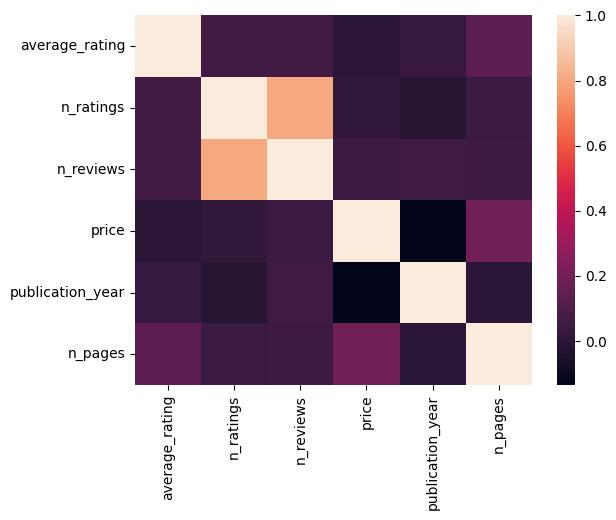

In [4]:
plt.figure()
sns.heatmap(df[["average_rating", "n_ratings", "n_reviews", "price", "publication_year", "n_pages"]].corr())
plt.savefig("../figures/correlation.svg", format="svg")
plt.show()

In [5]:
numeric_columns = df.select_dtypes(include="number")

with warnings.catch_warnings(action="ignore"):
    for col in numeric_columns:
        print(f"Is '{col}' normally distributed ? {shapiro(df[col].dropna()).pvalue > 0.05}")

Is 'price' normally distributed ? False
Is 'n_ratings' normally distributed ? False
Is 'n_reviews' normally distributed ? False
Is 'publication_year' normally distributed ? False
Is 'n_pages' normally distributed ? False
Is 'one_star' normally distributed ? False
Is 'two_stars' normally distributed ? False
Is 'three_stars' normally distributed ? False
Is 'four_stars' normally distributed ? False
Is 'five_stars' normally distributed ? False
Is 'average_rating' normally distributed ? False


In [6]:
formula = "average_rating ~ n_ratings*n_reviews*price"
model = ols(formula, data=df).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)
print()
print(model.summary())

                                sum_sq       df          F    PR(>F)
n_ratings                     0.681573      1.0   8.962026  0.002760
n_reviews                     0.153914      1.0   2.023817  0.154865
n_ratings:n_reviews           0.985337      1.0  12.956222  0.000320
price                         0.075165      1.0   0.988349  0.320159
n_ratings:price               0.004257      1.0   0.055981  0.812967
n_reviews:price               0.006016      1.0   0.079107  0.778514
n_ratings:n_reviews:price     0.228076      1.0   2.998974  0.083333
Residual                   1494.939437  19657.0        NaN       NaN

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     15.16
Date:                Wed, 22 May 2024   Prob (F-statistic):   

In [7]:
formula = "price ~ n_ratings*n_reviews*average_rating"
model = ols(formula, data=df).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)
print()
print(model.summary())

                                           sum_sq       df          F  \
n_ratings                              821.505478      1.0  19.337749   
n_reviews                             1901.701762      1.0  44.764925   
n_ratings:n_reviews                    429.389797      1.0  10.107580   
average_rating                          41.991752      1.0   0.988461   
n_ratings:average_rating               203.151819      1.0   4.782073   
n_reviews:average_rating               129.335935      1.0   3.044491   
n_ratings:n_reviews:average_rating      52.339777      1.0   1.232047   
Residual                            835067.888589  19657.0        NaN   

                                          PR(>F)  
n_ratings                           1.100945e-05  
n_reviews                           2.281499e-11  
n_ratings:n_reviews                 1.478897e-03  
average_rating                      3.201311e-01  
n_ratings:average_rating            2.876923e-02  
n_reviews:average_rating            

In [8]:
formula = "n_ratings ~ n_reviews*publication_year*n_pages"
model = ols(formula, data=df).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)
print()
print(model.summary())

                                          sum_sq       df             F  \
n_reviews                           5.050346e+14      1.0  48394.542215   
publication_year                    2.757425e+12      1.0    264.228021   
n_reviews:publication_year          6.865475e+13      1.0   6578.786757   
n_pages                             4.353521e+09      1.0      0.417173   
n_reviews:n_pages                   1.147383e+12      1.0    109.947017   
publication_year:n_pages            7.972927e+08      1.0      0.076400   
n_reviews:publication_year:n_pages  8.969392e+11      1.0     85.948481   
Residual                            1.993755e+14  19105.0           NaN   

                                          PR(>F)  
n_reviews                           0.000000e+00  
publication_year                    5.117518e-59  
n_reviews:publication_year          0.000000e+00  
n_pages                             5.183590e-01  
n_reviews:n_pages                   1.181597e-25  
publication_year:n

In [9]:
formula = "n_reviews ~ n_ratings*publication_year*n_pages"
model = ols(formula, data=df).fit()
table = sm.stats.anova_lm(model, typ=2)

print(table)
print()
print(model.summary())

                                          sum_sq       df             F  \
n_ratings                           9.310430e+11      1.0  42150.260881   
publication_year                    6.560791e+09      1.0    297.020700   
n_ratings:publication_year          6.688848e+10      1.0   3028.181055   
n_pages                             4.536052e+08      1.0     20.535654   
n_ratings:n_pages                   5.767555e+09      1.0    261.109244   
publication_year:n_pages            2.852781e+08      1.0     12.915136   
n_ratings:publication_year:n_pages  6.784252e+09      1.0    307.137248   
Residual                            4.220040e+11  19105.0           NaN   

                                          PR(>F)  
n_ratings                           0.000000e+00  
publication_year                    4.639171e-66  
n_ratings:publication_year          0.000000e+00  
n_pages                             5.888552e-06  
n_ratings:n_pages                   2.396804e-58  
publication_year:n

## Focus on the Accessibility

Total number of different formats: 

 8


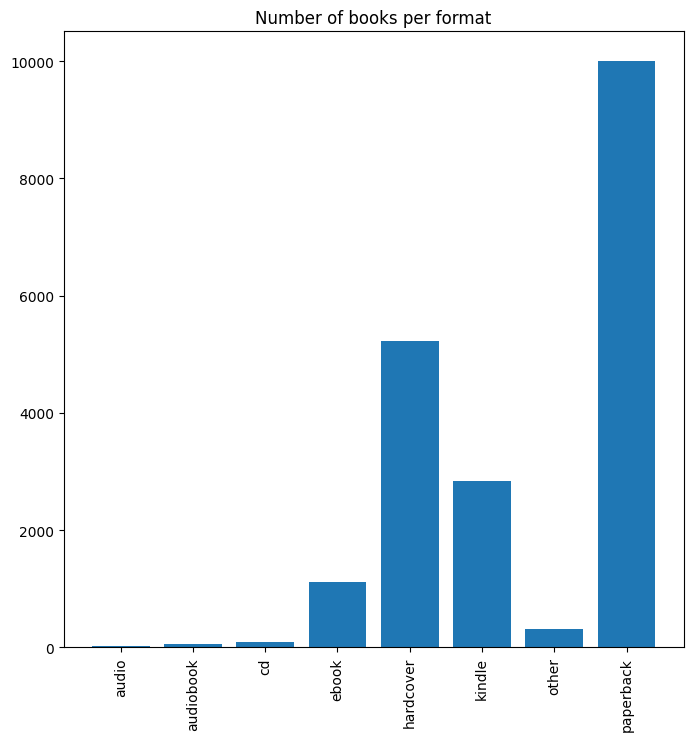

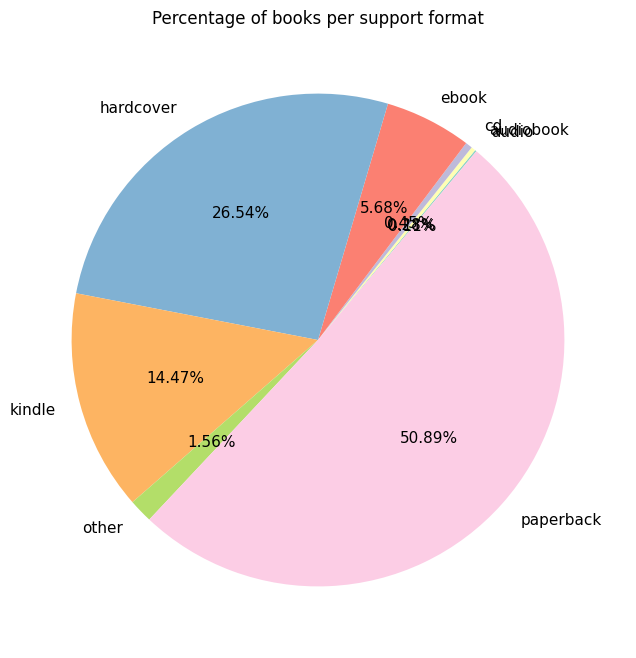

In [10]:
formats_list = np.unique(df["format"])
print("Total number of different formats: ", len(formats_list))

format_counts = df["format"].value_counts()
format_counts = [format_counts[format_key] for format_key in formats_list]

plt.figure(figsize=(8, 8))
plt.title("Number of books per format")
plt.bar(x=np.arange(len(formats_list)), height=format_counts, align="center")
plt.xticks(np.arange(len(formats_list)), formats_list, rotation=90)
plt.savefig("../figures/format_histplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Percentage of books per support format")
plt.pie(format_counts, labels=formats_list, autopct="%1.2f%%", colors=sns.color_palette("Set3"), textprops={"fontsize":11}, startangle=50)
plt.savefig("../figures/format_pie.svg", format="svg")
plt.show()

Total number of different languages:  33


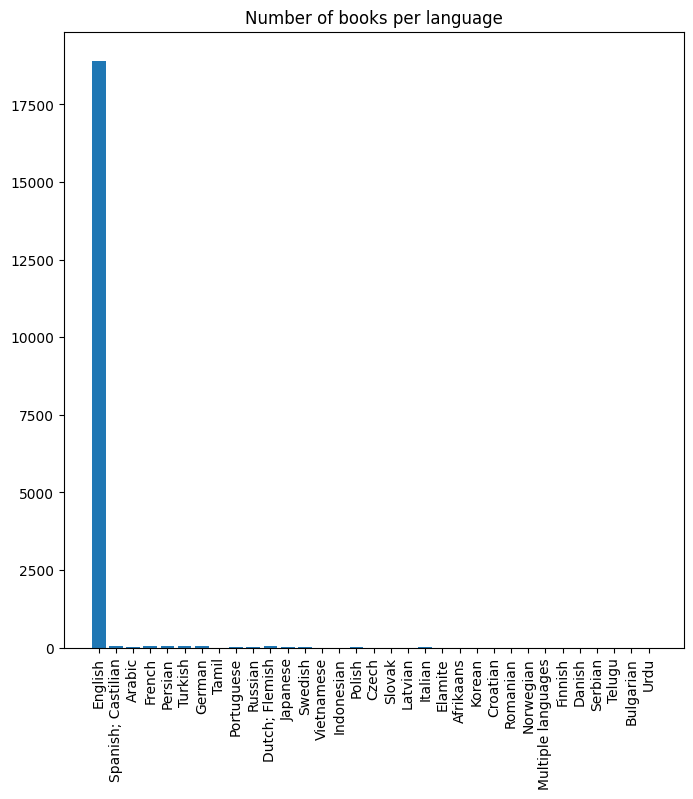

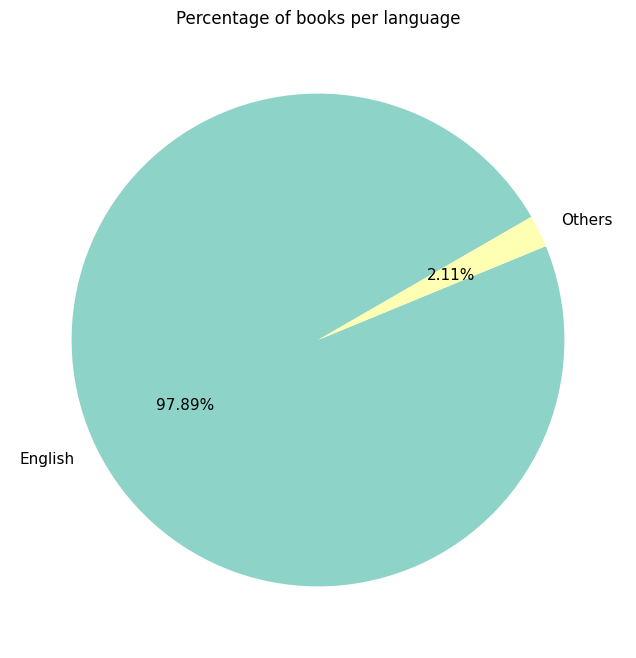

In [11]:
languages_list = df["language"].dropna().unique()
print("Total number of different languages: ", len(languages_list))

languages_counts = df["language"].value_counts()
languages_counts = [languages_counts[language] for language in languages_list]

plt.figure(figsize=(8, 8))
plt.title("Number of books per language")
plt.bar(x=np.arange(len(languages_list)), height=languages_counts, align="center")
plt.xticks(np.arange(len(languages_list)), languages_list, rotation=90)
plt.savefig("../figures/language_histplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Percentage of books per language")
pie_counts = [df["language"].value_counts()["English"], df["language"].value_counts().sum() - df["language"].value_counts()["English"]]
pie_list = ["English", "Others"]
plt.pie(pie_counts, labels=pie_list, autopct="%1.2f%%", colors=sns.color_palette("Set3"), textprops={"fontsize":11}, startangle=30)
plt.savefig("../figures/language_pie.svg", format="svg")
plt.show()

## Focus on the Authors

In [12]:
authors_groups = df.groupby("author")
authors_number_of_books = authors_groups.count().sort_values(by="title", ascending=False)
authors_number_of_books.head(5)

,title,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,publication_info,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
author,,,,,,,,,,,,,,,,,,,,,
Neil Gaiman,48,48,48,0,48,48,48,48,48,48,...,12,48,48,48,48,48,48,48,48,48
Stephen King,36,36,36,36,36,36,36,36,36,36,...,23,36,36,36,36,36,36,36,36,36
R.L. Stine,34,34,34,34,34,34,34,34,34,34,...,3,34,34,34,34,34,34,34,34,34
Nora Roberts,32,32,32,32,32,32,32,32,32,32,...,31,32,32,32,32,32,32,32,32,32
J.D. Robb,26,26,26,26,26,26,26,26,26,26,...,17,26,26,26,26,26,26,26,26,26


In [13]:
authors_number_of_books.describe()

,title,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,publication_info,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
count,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,...,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000,12061.000000
mean,1.630545,1.630545,1.630379,1.445237,1.630545,1.630545,1.630545,1.630545,1.630545,1.630545,...,0.477987,1.618937,1.618937,1.594229,1.630462,1.630462,1.630462,1.630462,1.630462,1.630462
std,1.792645,1.792645,1.792610,1.827627,1.792645,1.792645,1.792645,1.792645,1.792645,1.792645,...,1.180459,1.790444,1.790444,1.785100,1.792466,1.792466,1.792466,1.792466,1.792466,1.792466
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,48.000000,48.000000,48.000000,36.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,31.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000


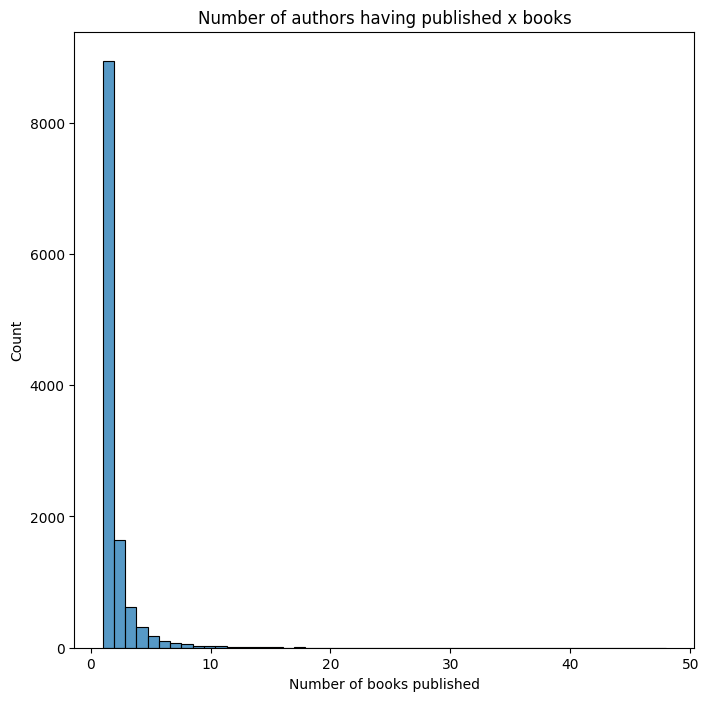

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Number of authors having published x books")
sns.histplot(authors_number_of_books, x="title", bins=50)
plt.xlabel("Number of books published")
plt.savefig("../figures/authors_histplot.svg", format="svg")
plt.show()

In our dataset, most authors have only written one book, the most prolific one having published 48 books. It is probably an outlier as we can expect 3 out of 4 authors to have written less than 2 books. Plus, the average author should have written only 1 or 2 books.

In [15]:
books_published_per_year = df.groupby("publication_year").count().sort_values(by="publication_year", ascending=False)
books_published_per_year.head(5)

,title,author,price,description,author_description,genres,n_ratings,n_reviews,ratings,pages_format,...,language,setting,publication_date,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
publication_year,,,,,,,,,,,,,,,,,,,,,
2024.0,69,69,69,69,57,69,69,69,69,69,...,67,9,69,67,69,69,69,69,69,69
2023.0,166,166,166,166,144,166,166,166,166,166,...,162,31,166,159,166,166,166,166,166,166
2022.0,218,218,218,218,172,218,218,218,218,218,...,213,42,218,211,218,218,218,218,218,218
2021.0,314,314,314,314,266,314,314,314,314,314,...,307,67,314,303,314,314,314,314,314,314
2020.0,394,394,394,394,320,394,394,394,394,394,...,385,72,394,378,394,394,394,394,394,394


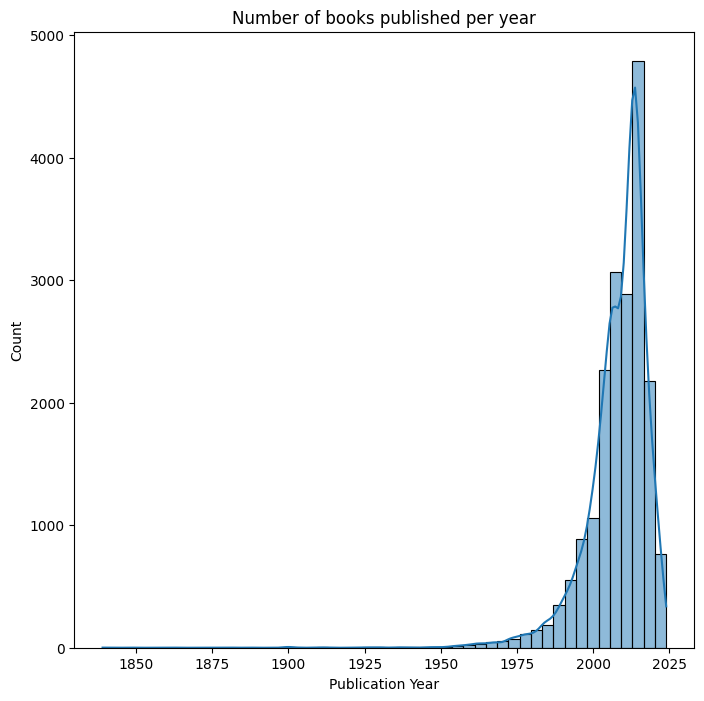

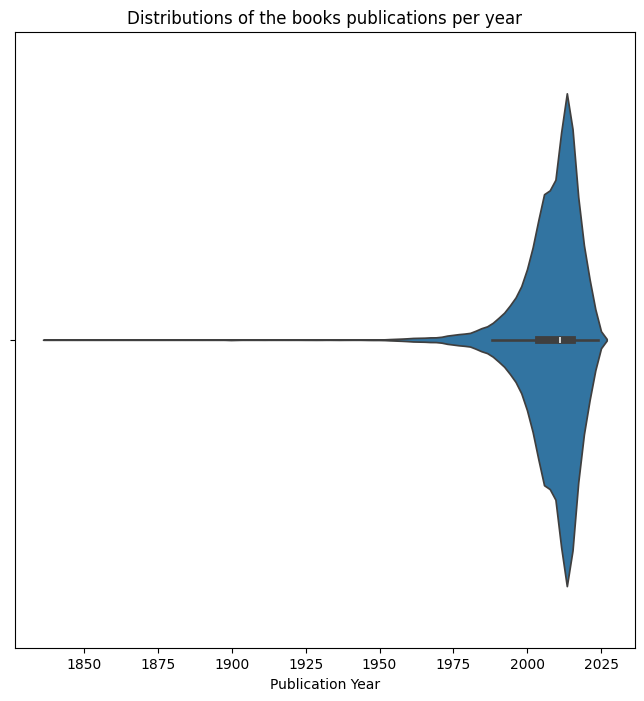

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Number of books published per year")
sns.histplot(df, x="publication_year", bins=50, kde=True)
plt.xlabel("Publication Year")
plt.savefig("../figures/publication_histplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8, 8))
plt.title("Distributions of the books publications per year")
sns.violinplot(df, x="publication_year")
plt.xlabel("Publication Year")
plt.savefig("../figures/publication_violinplot.svg", format="svg")
plt.show()

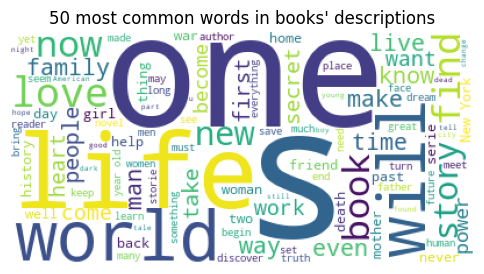

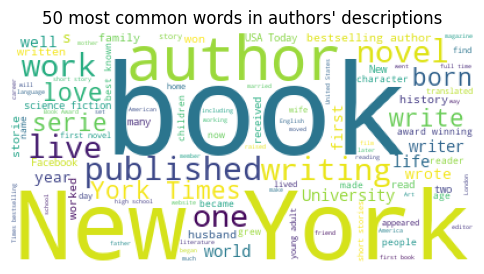

In [17]:
authors_descriptions = " ".join(df["author_description"].dropna())
books_descriptions = " ".join(df["description"].dropna())

wordcloud_authors = wc.WordCloud(background_color="white", max_words=100).generate(authors_descriptions)
wordcloud_books = wc.WordCloud(background_color="white", max_words=100).generate(books_descriptions)

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_books)
plt.title("50 most common words in books' descriptions")
plt.axis("off")
plt.savefig("../figures/wordcloud_books.svg", format="svg")
plt.show()

plt.figure(figsize=(6, 4))
plt.imshow(wordcloud_authors)
plt.title("50 most common words in authors' descriptions")
plt.axis("off")
plt.savefig("../figures/wordcloud_authors.svg", format="svg")
plt.show()

## Focus on the Genres

In [18]:
df_genres = df.explode("genres")
df_genres["genres"] = df_genres["genres"].apply(lambda x: x.strip()[1:-1]) 
df_genres["genres"].astype("category")
df_genres = df_genres[df_genres["genres"] != "...more"]

genres_groups = df_genres.groupby("genres")
genres_number_of_books = genres_groups.count().sort_values(by="title", ascending=False)
genres_number_of_books.head(5)

,title,author,price,description,author_description,n_ratings,n_reviews,ratings,pages_format,publication_info,...,setting,publication_date,publication_year,n_pages,one_star,two_stars,three_stars,four_stars,five_stars,average_rating
genres,,,,,,,,,,,,,,,,,,,,,
Fiction,9995,9995,9995,9993,9338,9995,9995,9995,9995,9995,...,4051,9935,9935,9863,9995,9995,9995,9995,9995,9995
Romance,6065,6065,6065,6064,5682,6065,6065,6065,6065,6065,...,2166,6025,6025,5897,6065,6065,6065,6065,6065,6065
Nonfiction,5116,5116,5116,5116,4023,5116,5116,5116,5116,5116,...,706,5079,5079,5021,5116,5116,5116,5116,5116,5116
Fantasy,4912,4912,4912,4912,4545,4912,4912,4912,4912,4912,...,1330,4873,4873,4808,4912,4912,4912,4912,4912,4912
Young Adult,3813,3813,3813,3813,3504,3813,3813,3813,3813,3813,...,1209,3786,3786,3744,3813,3813,3813,3813,3813,3813


Total number of different genres:  810


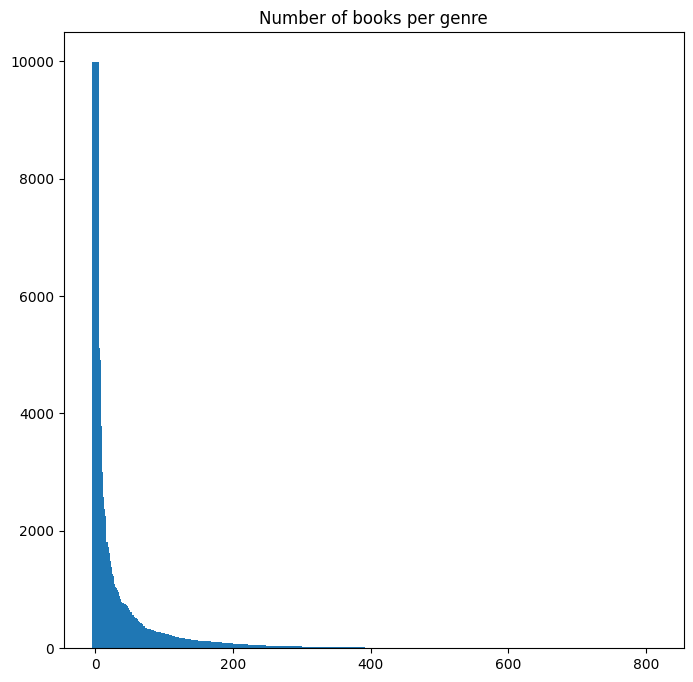

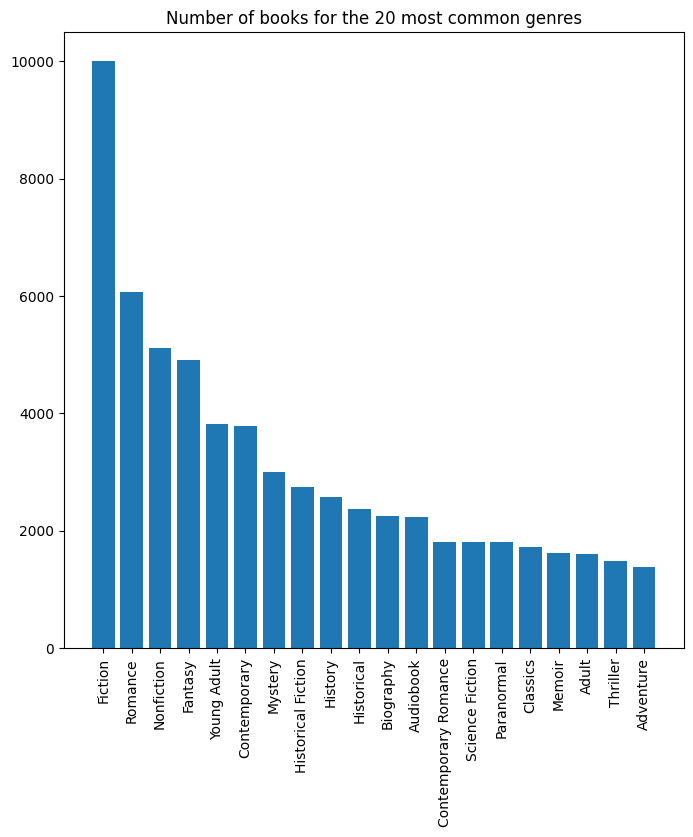

In [19]:
genres_list = np.unique(df_genres["genres"])
print("Total number of different genres: ", len(genres_list))

genres_dict = {genre: i for i, genre in enumerate(genres_list)}
genres_counts = df_genres["genres"].value_counts()

plt.figure(figsize=(8, 8))
plt.title("Number of books per genre")
plt.bar(x=np.arange(len(genres_list)), height=genres_counts, align="center", width=10)
plt.savefig("../figures/genres_histplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8, 8))
most_common_genres_counts = genres_counts.head(20)
plt.title("Number of books for the 20 most common genres")
plt.bar(x=np.arange(len(most_common_genres_counts)), height=most_common_genres_counts, align="center")
plt.xticks(np.arange(len(most_common_genres_counts)), most_common_genres_counts.index, rotation=90)
plt.savefig("../figures/genres_histplot20.svg", format="svg")
plt.show()

In [20]:
df_genres_year = df_genres.groupby(["publication_year", "genres"]).count().sort_values(by=["publication_year", "title"], ascending=False).groupby(level=0).head(5)
df_genres_year.head(10)

title  author  price  description  \
publication_year genres                                                  
2024.0           Fiction                36      36     36           36   
                 Romance                31      31     31           31   
                 Contemporary           24      24     24           24   
                 Fantasy                19      19     19           19   
                 Historical Fiction     17      17     17           17   
2023.0           Romance                80      80     80           80   
                 Fiction                76      76     76           76   
                 Contemporary           58      58     58           58   
                 Audiobook              36      36     36           36   
                 Fantasy                36      36     36           36   

                                     author_description  n_ratings  n_reviews  \
publication_year genres                                                         
2024.0           Fiction                             29         36         36   
                 Romance                             28         31         31   
                 Contemporary                        22         24         24   
                 Fantasy                             16         19         19   
                 Historical Fiction                  13         17         17   
2023.0           Romance                             72         80         80   
                 Fiction                             70         76         76   
                 Contemporary                        50         58         58   
                 Audiobook                           33         36         36   
                 Fantasy                             33         36         36   

                                     ratings  pages_format  publication_info  \
publication_year genres                                                        
2024.0           Fiction                  36            36                36   
                 Romance                  31            31                31   
                 Contemporary             24            24                24   
                 Fantasy                  19            19                19   
                 Historical Fiction       17            17                17   
2023.0           Romance                  80            80                80   
                 Fiction                  76            76                76   
                 Contemporary             58            58                58   
                 Audiobook                36            36                36   
                 Fantasy                  36            36                36   

                                     ...  language  setting  publication_date  \
publication_year genres              ...                                        
2024.0           Fiction             ...        35        6                36   
                 Romance             ...        29        1                31   
                 Contemporary        ...        23        2                24   
                 Fantasy             ...        18        3                19   
                 Historical Fiction  ...        16        6                17   
2023.0           Romance             ...        79       12                80   
                 Fiction             ...        75       26                76   
                 Contemporary        ...        58       15                58   
                 Audiobook           ...        35       13                36   
                 Fantasy             ...        35        2                36   

                                     n_pages  one_star  two_stars  \
publication_year genres                                             
2024.0           Fiction                  36        36         36   
                 Romance          

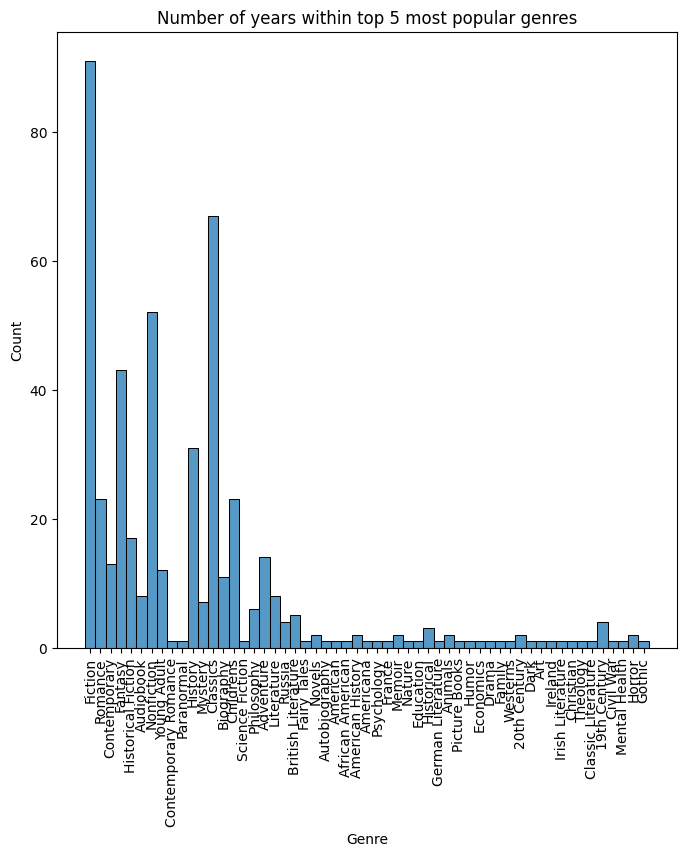

In [21]:
plt.figure(figsize=(8, 8))
plt.title("Number of years within top 5 most popular genres")
sns.histplot(df_genres_year, x="genres")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.savefig("../figures/genres_histplot_years.svg", format="svg")
plt.show()

## Focus on the Prices

In [22]:
prices = df["price"].dropna()
prices.describe()

count    19666.000000
mean         7.719634
std          6.527542
min          0.000000
25%          2.990000
50%          7.990000
75%         11.577500
max        199.730000
Name: price, dtype: float64

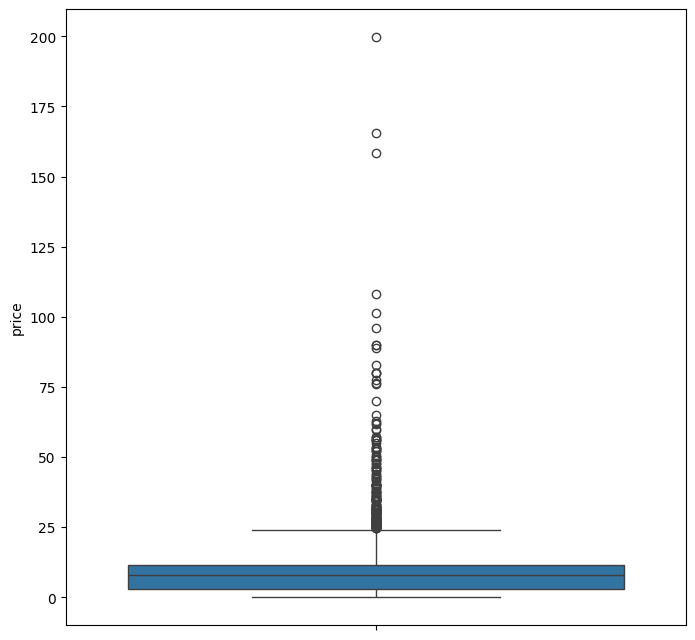

In [23]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=prices)
plt.savefig("../figures/prices_boxplot.svg", format="svg")
plt.show()

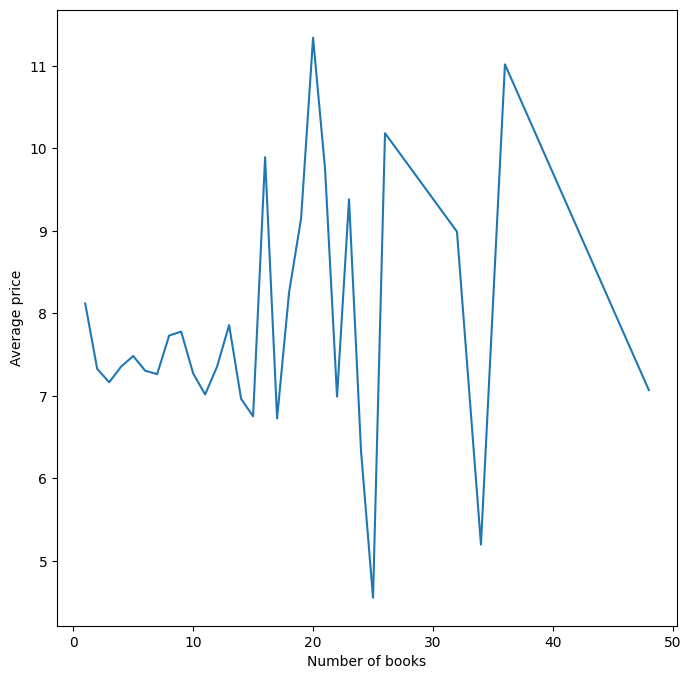

In [24]:
authors_prices_groups = df[["author", "price"]].groupby("author")
authors_prices = authors_prices_groups.mean().sort_values(by="price", ascending=False)
authors_prices["n_books"] = authors_prices_groups.count()

average_prices_per_n_books = authors_prices.groupby("n_books").mean()

plt.figure(figsize=(8, 8))
sns.lineplot(average_prices_per_n_books, x="n_books", y="price")
plt.xlabel("Number of books")
plt.ylabel("Average price")
plt.savefig("../figures/authors_prices_scatterplot.svg", format="svg")
plt.show()

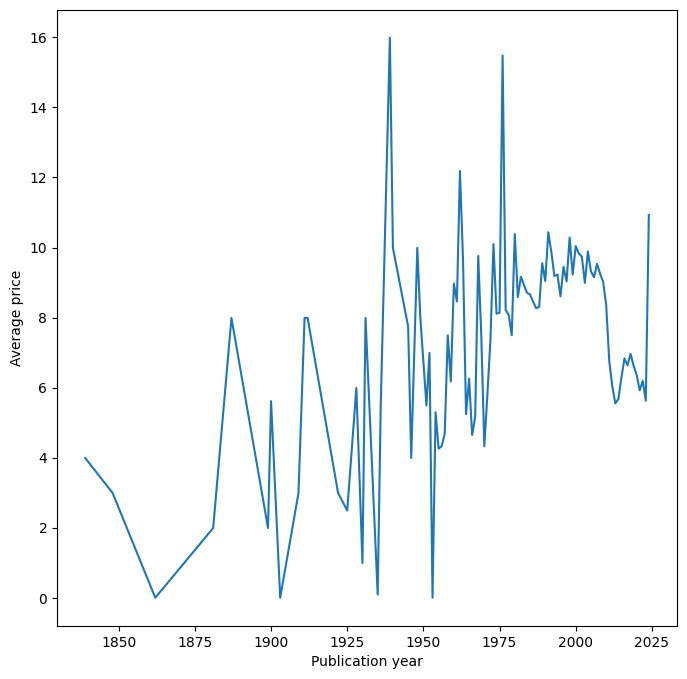

In [25]:
average_prices = df.groupby("publication_year")["price"].mean()

plt.figure(figsize=(8, 8))
sns.lineplot(data=average_prices)
plt.xlabel("Publication year")
plt.ylabel("Average price")
plt.savefig("../figures/prices_scatterplot.svg", format="svg")
plt.show()

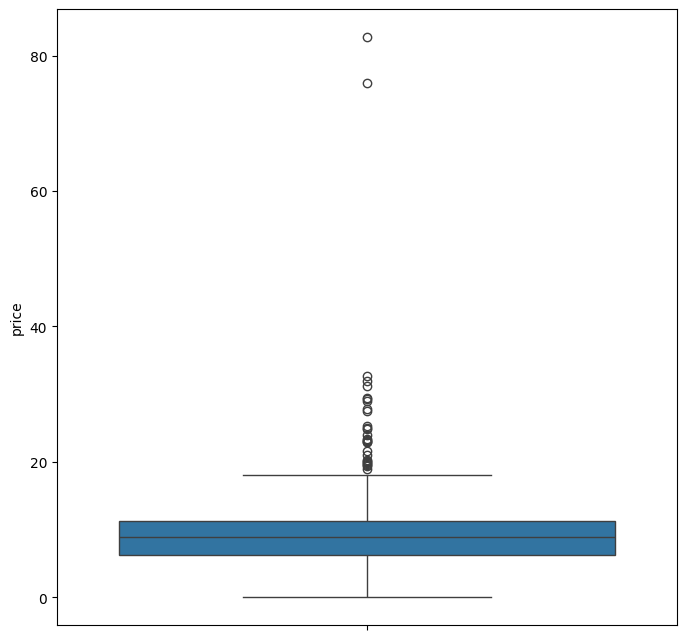

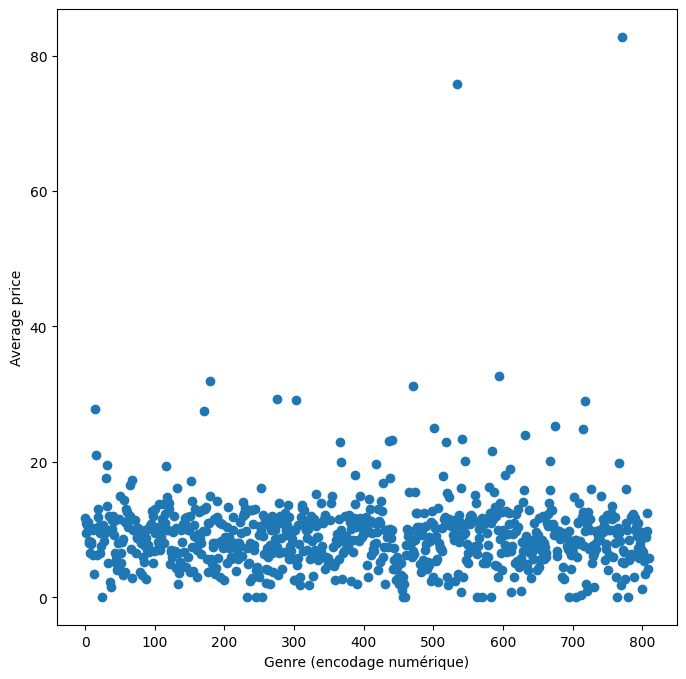

In [26]:
genres_average_prices = genres_groups["price"].mean()

plt.figure(figsize=(8, 8))
sns.boxplot(data=genres_average_prices)
plt.savefig("../figures/genres_prices_boxplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(np.arange(len(genres_list)), genres_average_prices)
plt.xlabel("Genre (encodage numérique)")
plt.ylabel("Average price")
plt.savefig("../figures/genres_prices_histplot.svg", format="svg")
plt.show()

## Focus on the Ratings

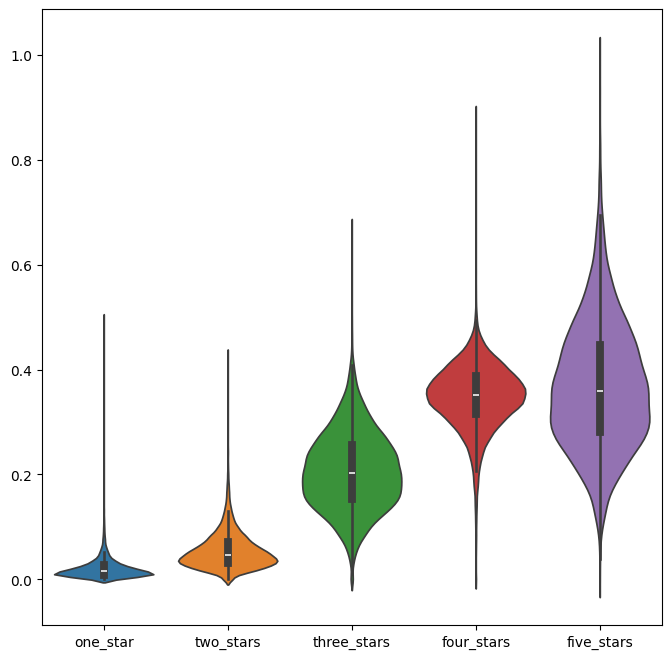

In [27]:
plt.figure(figsize=(8, 8))
sns.violinplot(data=df[["one_star", "two_stars", "three_stars", "four_stars", "five_stars"]])
plt.savefig("../figures/ratings_violinplot.svg", format="svg")
plt.show()

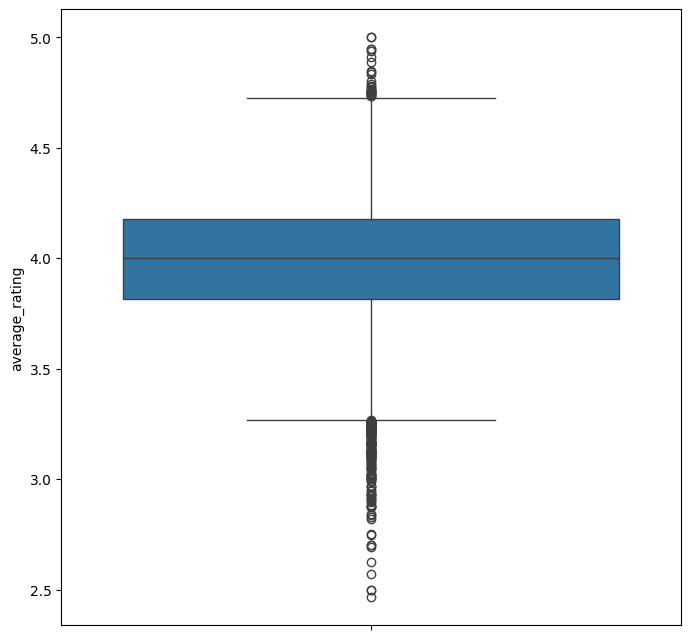

In [28]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df["average_rating"])
plt.savefig("../figures/ratings_boxplot.svg", format="svg")
plt.show()

From this boxplot, we can deduce that:
- The distribution is biased, so the scraped books are mainly books with great ratings
- Users give high ratings in average
- Most books are worth your time

In [29]:
authors_average_rating = df[["author", "average_rating", "n_ratings"]].groupby("author").mean().sort_values(by="average_rating", ascending=False)
authors_average_rating.head(5)

,average_rating,n_ratings
author,,
Phillip B. Chute,5.000000,3.0
J. David Clarke,5.000000,2.0
Elias Zapple,4.946429,56.0
A. Razor,4.944444,18.0
Isabel Ibañez,4.909091,22.0


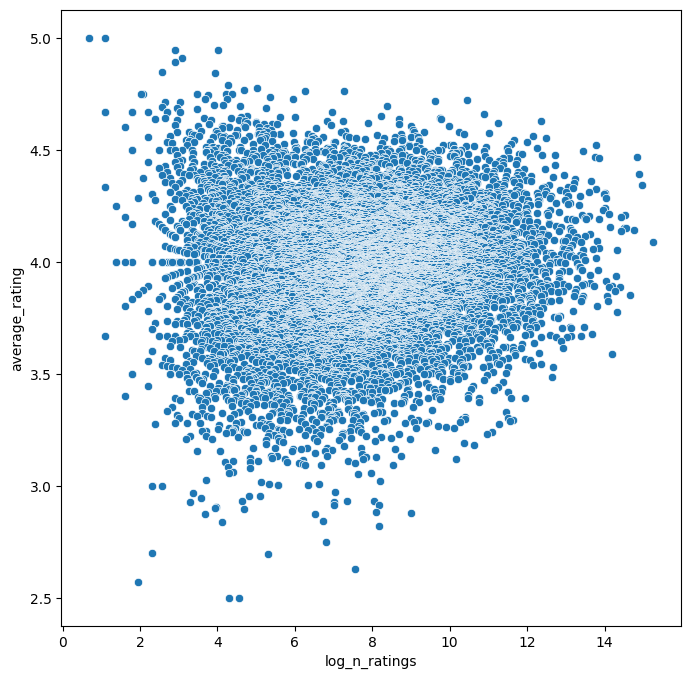

In [30]:
authors_average_rating["log_n_ratings"] = np.log(authors_average_rating["n_ratings"])

plt.figure(figsize=(8, 8))
sns.scatterplot(authors_average_rating, x="log_n_ratings", y="average_rating")
plt.savefig("../figures/average_ratings_scatterplot.svg", format="svg")
plt.show()

Books with few ratings seem to receive more extreme ratings (positive as well as negative), whereas books with a lot of ratings have more uniform ratings (between 3.5 and 4.5).

<Figure size 800x800 with 0 Axes>

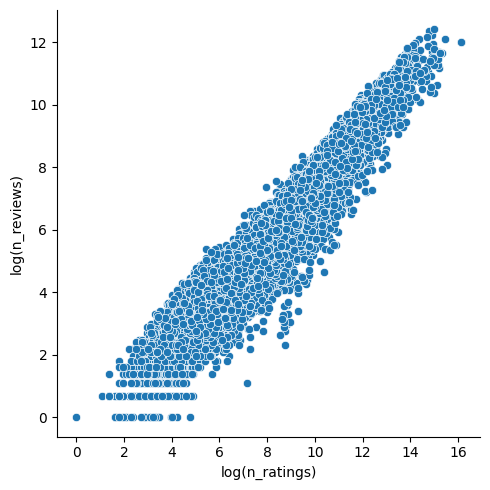

In [31]:
plt.figure(figsize=(8, 8))
sns.relplot(data=df, x=np.log(df["n_ratings"] + 1), y=np.log(df["n_reviews"] + 1))
plt.xlabel("log(n_ratings)")
plt.ylabel("log(n_reviews)")
plt.savefig("../figures/ratings_reviews_scatterplot.svg", format="svg")
plt.show()

In [32]:
p = pearsonr(df["n_ratings"], df["n_reviews"])
p_loglog = pearsonr(np.log(df["n_ratings"] + 1), np.log(df["n_reviews"] + 1))

print(f"Pearson Coefficient: {p.statistic:.2f}", )
print(f"Pearson Coefficient (log-log): {p_loglog.statistic:.2f}", )

Pearson Coefficient: 0.81
Pearson Coefficient (log-log): 0.95


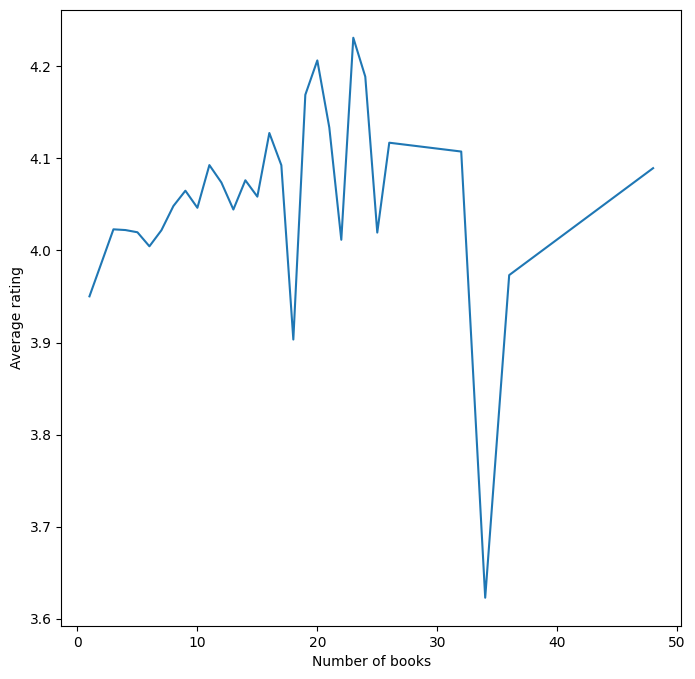

In [33]:
authors_ratings_groups = df[["author", "average_rating"]].groupby("author")
authors_ratings = authors_ratings_groups.mean().sort_values(by="average_rating", ascending=False)
authors_ratings["n_books"] = authors_ratings_groups.count()

average_ratings_per_n_books = authors_ratings.groupby("n_books").mean()

plt.figure(figsize=(8, 8))
sns.lineplot(average_ratings_per_n_books, x="n_books", y="average_rating")
plt.xlabel("Number of books")
plt.ylabel("Average rating")
plt.savefig("../figures/books_ratings_scatterplot.svg", format="svg")
plt.show()

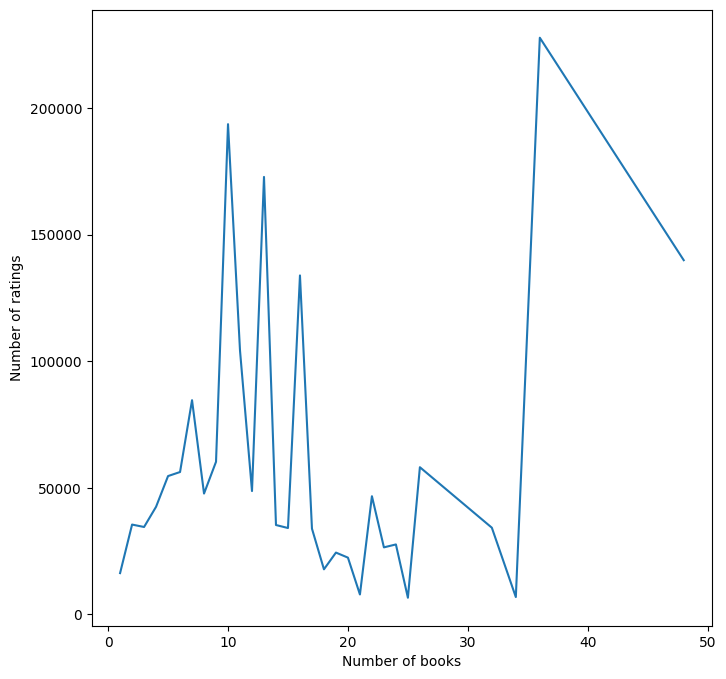

In [34]:
authors_ratings_groups = df[["author", "n_ratings"]].groupby("author")
authors_ratings = authors_ratings_groups.mean().sort_values(by="n_ratings", ascending=False)
authors_ratings["n_books"] = authors_ratings_groups.count()

average_ratings_per_n_books = authors_ratings.groupby("n_books").mean()

plt.figure(figsize=(8, 8))
sns.lineplot(average_ratings_per_n_books, x="n_books", y="n_ratings")
plt.xlabel("Number of books")
plt.ylabel("Number of ratings")
plt.savefig("../figures/books_n_ratings_scatterplot.svg", format="svg")
plt.show()

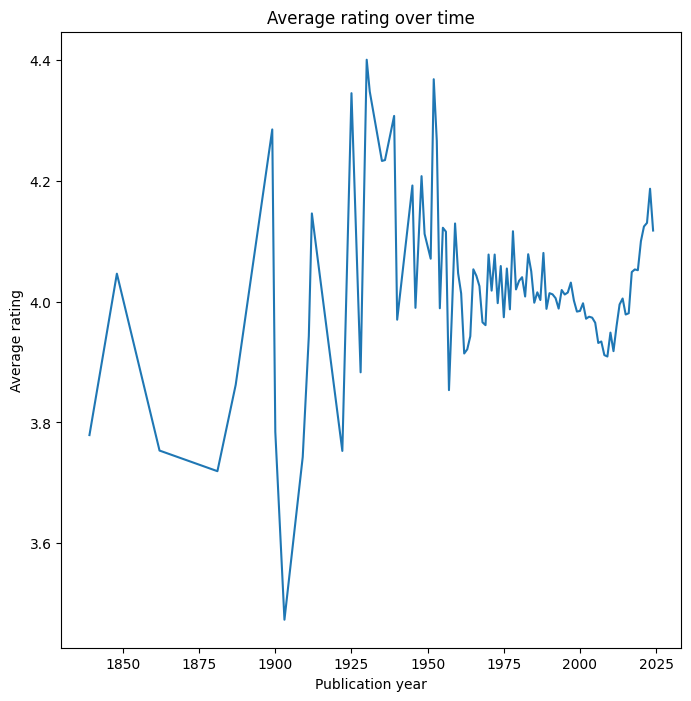

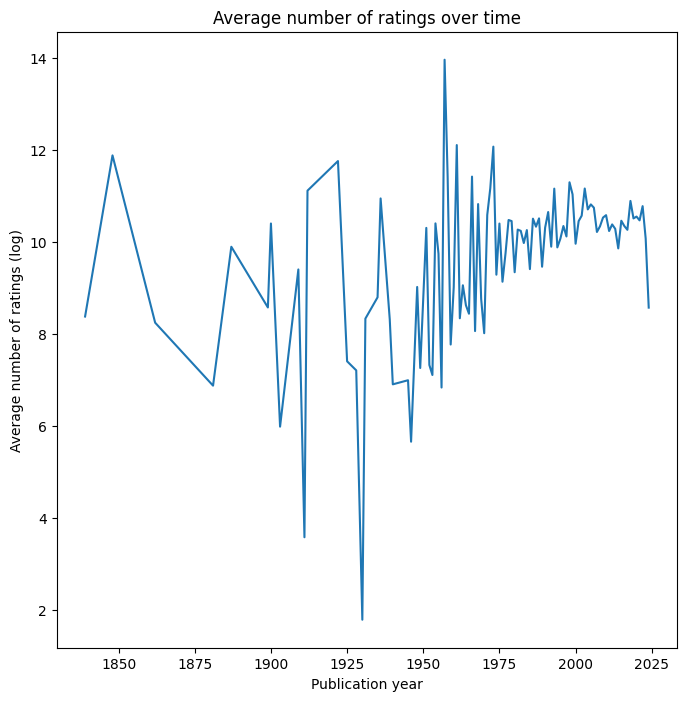

In [35]:
ratings_over_time = df.groupby("publication_year")[["average_rating", "n_ratings"]].mean()
ratings_over_time["log_n_ratings"] = np.log(ratings_over_time["n_ratings"] + 1)

plt.figure(figsize=(8 ,8))
plt.title("Average rating over time")
sns.lineplot(data=ratings_over_time, x=ratings_over_time.index, y="average_rating")
plt.xlabel("Publication year")
plt.ylabel("Average rating")
plt.savefig("../figures/average_ratings_over_time_scatterplot.svg", format="svg")
plt.show()

plt.figure(figsize=(8 ,8))
plt.title("Average number of ratings over time")
sns.lineplot(data=ratings_over_time, x=ratings_over_time.index, y="log_n_ratings")
plt.xlabel("Publication year")
plt.ylabel("Average number of ratings (log)")
plt.savefig("../figures/ratings_over_time_scatterplot.svg", format="svg")
plt.show()